# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [6]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

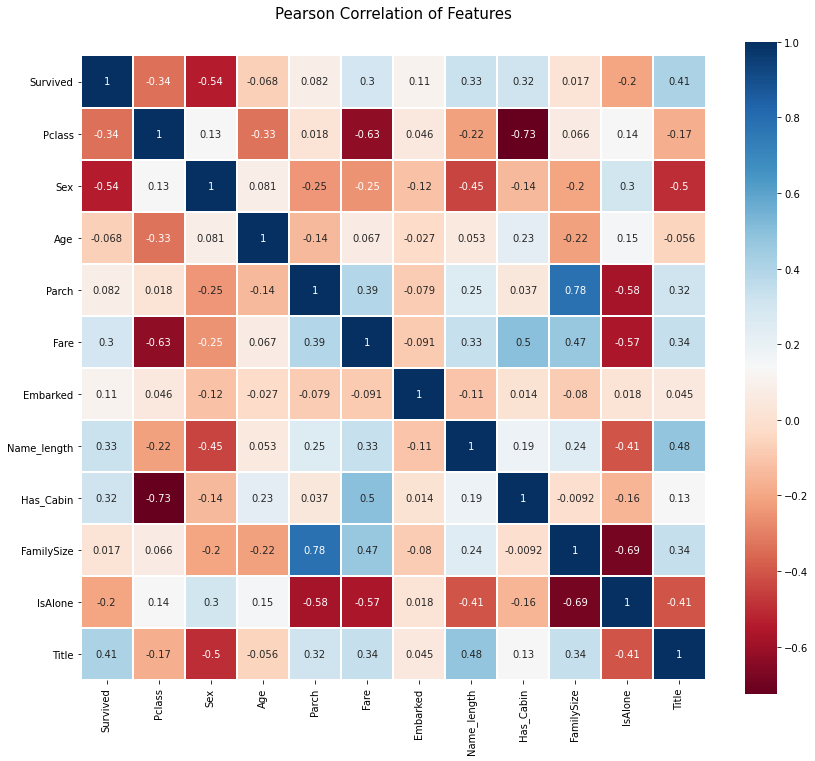

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

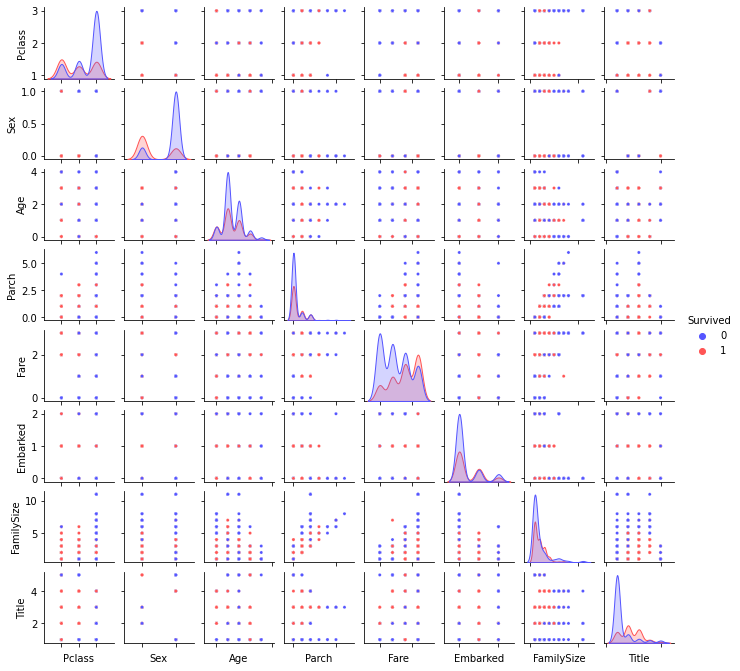

In [13]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])
plt.show()

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [117]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)


# выделяем из тренировочного дата сета признаки и цели
train_targets = train.Survived
train_data = train.drop(columns='Survived')

# разбиваем данные
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    train_targets,
                                                    test_size=0.3,
                                                    random_state=17)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [118]:
# создаем экземпляр каждого базового алгоритма
gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
lr = LogisticRegression(random_state=17)
svc = SVC(random_state=17)

# словарь базовых алгоритмов с параметрами 
est_params_dict = {gbc: gbc_params,
                   rfc: rfc_params, 
                   lr: lr_params, 
                   svc: svc_params}

# вспомогательный список названий моделей и счетчик
models = ['GradientBoostingClassifier', 
          'RandomForestClassifier', 
          'LogisticRegression', 
          'SVC']


In [113]:
svc

SVC(random_state=17)

In [212]:
# счетчик
counter = 0

# словарь лучших параметров для базовых алгоритмов
models_best_params = {}

# определение матрицы метапризнаков
meta_mtrx = np.empty((x_test.shape[0], len(models)))
            
# подбираем параметры
for est, params in est_params_dict.items():
    
    # создаем экземпляр GridSearch и подбираем лучшие параметры для каждого алгоритма на тренировочных данных
    grid = GridSearchCV(est, params, cv=skf)
    grid.fit(x_train, y_train)
    
    # получам предсказание на тестовых данных
    y_pred = grid.predict(x_test)
    
    # получаем метрику качества
    score = grid.score(x_test, y_test)
    
    # добавляем в матрицу метапризнаков полученные предсказания
    meta_mtrx[:, counter] = y_pred
    
    # заполняем словарь лучших параметров
    models_best_params.update([(models[counter], grid.best_params_)])
    
    # выводим результаты для каждого алгоритма: лучшие параметры, предсказания, метрика
    print(f'\nresults of model {models[counter]}\n')
    print(f'best params:\n {grid.best_params_}\n')
    print(f'predictions:\n {y_pred}\n')
    print(f'score:\n {score}\n')
    counter += 1



results of model GradientBoostingClassifier

best params:
 {'learning_rate': 0.1}

predictions:
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0
 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0]

score:
 0.7686567164179104


results of model RandomForestClassifier

best params:
 {'min_samples_leaf': 3, 'n_estimators': 60}

predictions:
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0
 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 

### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [109]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

# создаем экземпляр мета-алгоритма
xgb = XGBClassifier(random_state=17)

In [110]:
# подбираем параметры мета-алгоритма
meta_grid = GridSearchCV(xgb, xgb_params, cv=skf, n_jobs=-1, verbose=True)
meta_grid.fit(meta_mtrx, y_test)


Fitting 5 folds for each of 7290 candidates, totalling 36450 fits
[17:38:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missin...
                                     num_parallel_tree=None, random_state=17,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                

In [216]:
# лучшие параметры
xgb_best_params=meta_grid.best_params_
print(f'best XGBClassifier params:\n {xgb_best_params}\n')


best XGBClassifier params:
 {'eta': 0.30000000000000004, 'min_child_weight': 2, 'n_estimators': 90, 'subsample': 0.1}



### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [168]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

# сокращенная функция стекинга из прошлого дз
def stacking(models, 
             meta_alg, 
             data_train, 
             targets_train, 
             data_test, 
             targets_test=None, 
             random_state=None, 
             test_size=None, 
             cv=5):
# 
    if test_size is None:
        # определение и заполнение матрицы метапризнаков
        meta_mtrx = np.empty((targets_train.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=cv, method='predict')
            model.fit(data_train, targets_train)
            
        # мета-модель
        meta_model = meta_alg.fit(meta_mtrx, targets_train)
        
        # определение и заполнение матрицы предсказаний
        meta_mtrx_test = np.empty((data_test.shape[0], len(models))) 
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
            
        # предсказания мета-модели
        meta_predict = meta_alg.predict(meta_mtrx_test)
        
        # метрика для предсказаний мета-модели на тестовых данных (при их наличии)
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')

    
    return meta_predict

In [218]:
# дополним словарь лучших параметров базовых алгоритмов параметром random_state
for key, value in models_best_params.items():
    models_best_params[key].update([('random_state', 17)])

models_best_params

{'GradientBoostingClassifier': {'learning_rate': 0.1, 'random_state': 17},
 'RandomForestClassifier': {'min_samples_leaf': 3,
  'n_estimators': 60,
  'random_state': 17},
 'LogisticRegression': {'C': 0.8999999999999999, 'random_state': 17},
 'SVC': {'C': 0.1, 'kernel': 'linear', 'random_state': 17}}

In [226]:
# обучаем новые экземпляры базовых алгоритмов на лучших параметрах
# xgb_best = XGBClassifier(xgb_best_params)
# gbc_best = GradientBoostingClassifier(models_best_params['GradientBoostingClassifier'])
# rfc_best = RandomForestClassifier(models_best_params['RandomForestClassifier'])
# lr_best = LogisticRegression(models_best_params['LogisticRegression'])
# svc_best = SVC(models_best_params['SVC'])

In [227]:
xgb_best = XGBClassifier(eta=0.1, min_child_weight=1, n_estimators=25, subsample=0.5)
gbc_best = GradientBoostingClassifier(learning_rate=0.1, random_state=17)
rfc_best = RandomForestClassifier(min_samples_leaf=2, n_estimators=30, random_state=17)
lr_best = SVC(C=0.9, kernel='rbf', random_state=17)
svc_best = LogisticRegression(C=0.89, random_state=17)

In [229]:
predictions = stacking(models=[gbc_best, rfc_best, lr_best, svc_best], 
                       meta_alg=xgb_best,
                       data_train=train_data,
                       targets_train=train_targets,
                       data_test=test,
                       targets_test=None,
                       random_state=17,
                       test_size=None,
                       cv=5)

[15:42:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [242]:
def write_to_submission_file(meta_predictions, 
                             PassengerID, 
                             out_file='Submission.csv', 
                             columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [245]:
write_to_submission_file(meta_predictions=predictions, PassengerID=test.index.to_list())

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ:
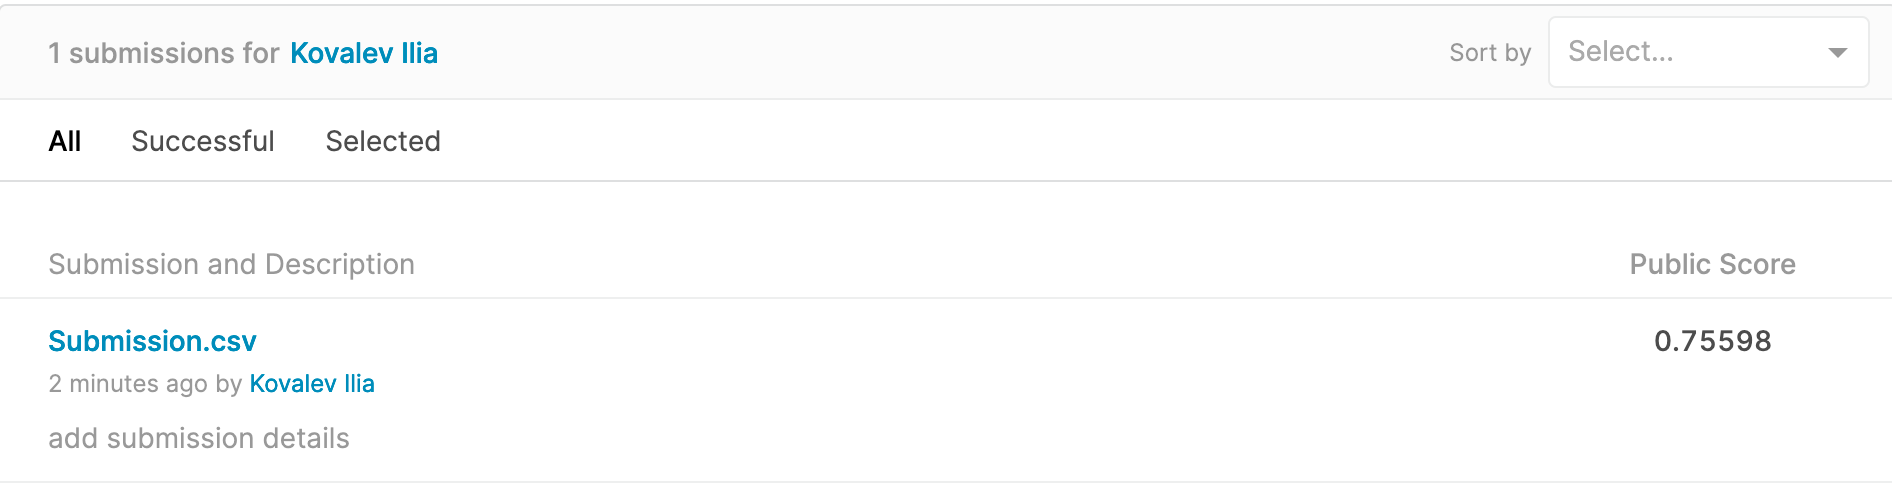